In [1]:
import os
from glob import glob
from typing import Dict

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.swa_utils import update_bn

import torchvision.transforms as T
from torchvision.models import resnet18
from torchvision.datasets import CIFAR10

from tqdm.notebook import tqdm, trange

mean = [0.4914, 0.4822, 0.4465]
std  = [0.2470, 0.2435, 0.2616]
input_size = 32

test_transform  = T.Compose([
    T.ToTensor(), 
    T.Normalize(mean, std)
])

test_set = CIFAR10("/opt/datasets/cifar10", train=False, download=True, transform=test_transform)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)


def create_model() -> nn.Module:
    model = resnet18(pretrained=False, num_classes=10)
    model.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
    model.maxpool = nn.Identity()
    return model


def load_model_from_checkpoint(ckpt: str) -> nn.Module:
    model = create_model()
    checkpoint = torch.load(ckpt, map_location='cpu')
    state_dict = checkpoint['state_dict']
    msg = model.load_state_dict(state_dict, strict=True)
    print(msg)
    return model


@torch.no_grad()
def evaluate(model: nn.Module, dataloader: DataLoader, device: torch.device) -> Dict[str, torch.Tensor]:
    
    # Update BNs from dataloader.
    update_bn(dataloader, model, device)

    all_targets = []
    all_logits = []
    
    model.eval()
    for imgs, lbls in dataloader:
        if device is not None:
            imgs, lbls = imgs.to(device), lbls.to(device)
        logits = model(imgs)
        all_targets.append(lbls)
        all_logits.append(logits)
    
    all_targets = torch.cat(all_targets, dim=0)
    all_logits  = torch.cat(all_logits, dim=0)

    return {
        "logits": all_logits,
        "targets": all_targets
    }

Files already downloaded and verified


In [2]:
TRAIN_SIZE = 2000

checkpoints = []

# EXP_DIR = './empirical/ensemble_20220923_163947/'
# checkpoints = glob(os.path.join(EXP_DIR, f"model_size={TRAIN_SIZE}*.pt"))
# print(f"Found {len(checkpoints)} checkpoints.")

# EXP_DIR = './empirical/ensemble_20220922_*/'
# checkpoints += glob(os.path.join(EXP_DIR, f"model_size={TRAIN_SIZE}*.pt"))
# print(f"Found {len(checkpoints)} checkpoints.")

EXP_DIR = './empirical/swa_20220922_185019/'
checkpoints += glob(os.path.join(EXP_DIR, f"model_size={TRAIN_SIZE}*.pt"))
print(f"Found {len(checkpoints)} checkpoints.")

models = [load_model_from_checkpoint(ckpt) for ckpt in checkpoints]

Found 5 checkpoints.
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>


In [3]:
gather_all_weights = []

for model in models:
    all_weights = []
    for n, p in model.named_parameters():
        if "bn" not in n:
            all_weights.append(p.data.flatten().numpy())
    all_weights = np.hstack(all_weights)
    gather_all_weights.append(all_weights)

gather_all_weights = np.vstack(gather_all_weights)
gather_all_weights.shape

(5, 11166154)

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
fitted_weight_space = pca.fit_transform(gather_all_weights)

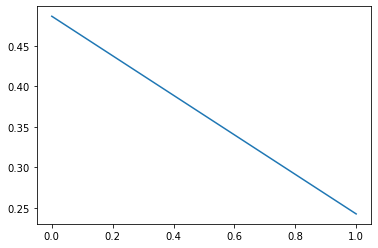

In [5]:
plt.plot(pca.explained_variance_ratio_)

In [6]:
maxs = fitted_weight_space.max(axis=0)
mins = fitted_weight_space.min(axis=0)

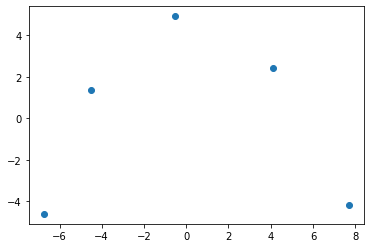

In [7]:
plt.scatter(fitted_weight_space[:, 0], fitted_weight_space[:, 1])

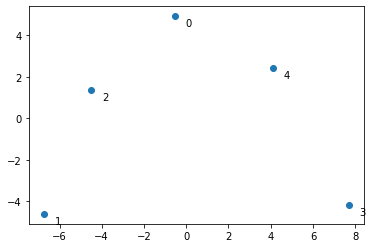

In [8]:
plt.scatter(fitted_weight_space[:, 0], fitted_weight_space[:, 1])
for i in range(len(fitted_weight_space)):
    plt.text(fitted_weight_space[i, 0]+0.5, fitted_weight_space[i, 1]-0.5, s=str(i))

In [9]:
maxs = fitted_weight_space.max(axis=0)
mins = fitted_weight_space.min(axis=0)

xs = np.linspace(mins[0]-2, maxs[0]+2, 31)
ys = np.linspace(mins[1]-2, maxs[1]+2, 31)
x_grid, y_grid = np.meshgrid(xs, ys)

In [10]:
device = torch.device('cuda')

nlls = np.zeros((len(xs), len(ys)))
accs = np.zeros((len(xs), len(ys)))

for i in range(len(xs)):

    for j in range(len(ys)):

        x_pt, y_pt = xs[i], ys[j]
        pt_at_grid = np.array([x_pt, y_pt])
        transformed_weights = pca.inverse_transform(pt_at_grid)
        
        weight_idx = 0
        model = create_model()

        for n, p in model.named_parameters():
            if "bn" not in n:
                shape = p.data.shape
                numel = p.data.numel()

                weight_copy = transformed_weights[weight_idx:weight_idx+numel].copy()
                weight_copy = weight_copy.reshape(shape)
                weight_copy = torch.tensor(weight_copy, dtype=p.dtype)
                p.data.copy_(weight_copy)
                
                weight_idx += numel
            
        model.to(device)
        eval_results = evaluate(model, test_loader, device)
        logits = eval_results['logits'].cpu()
        targets = eval_results['targets'].cpu()
        preds = torch.argmax(logits, dim=1)

        nll = F.cross_entropy(logits, targets)
        acc = (preds == targets).float().mean()
        nlls[i, j] = nll.item()
        accs[i, j] = acc.item()

        print(f"{acc:.3f}", end=' ')
        
    print()

0.426 0.432 0.439 0.444 0.449 0.454 0.459 0.463 0.467 0.468 0.468 0.468 0.468 0.470 0.469 0.468 0.467 0.463 0.461 0.456 0.451 0.447 0.442 0.440 0.432 0.425 0.419 0.411 0.403 0.395 0.387 
0.435 0.442 0.447 0.453 0.457 0.463 0.468 0.472 0.474 0.476 0.478 0.478 0.478 0.477 0.476 0.474 0.472 0.472 0.467 0.465 0.461 0.459 0.453 0.447 0.441 0.434 0.425 0.419 0.410 0.402 0.395 
0.443 0.451 0.456 0.464 0.468 0.474 0.476 0.480 0.482 0.485 0.486 0.487 0.483 0.483 0.482 0.483 0.481 0.480 0.478 0.475 0.470 0.465 0.458 0.454 0.448 0.441 0.436 0.426 0.417 0.408 0.401 
0.450 0.457 0.465 0.469 0.475 0.482 0.485 0.488 0.492 0.494 0.494 0.494 0.495 0.493 0.491 0.490 0.490 0.490 0.489 0.483 0.477 0.472 0.466 0.461 0.455 0.448 0.441 0.434 0.424 0.415 0.408 
0.459 0.466 0.473 0.477 0.483 0.489 0.496 0.496 0.500 0.501 0.500 0.500 0.501 0.501 0.501 0.500 0.500 0.498 0.495 0.494 0.489 0.483 0.476 0.470 0.462 0.455 0.449 0.440 0.432 0.424 0.416 
0.470 0.475 0.483 0.488 0.494 0.500 0.504 0.506 0.506 0.507 0.510

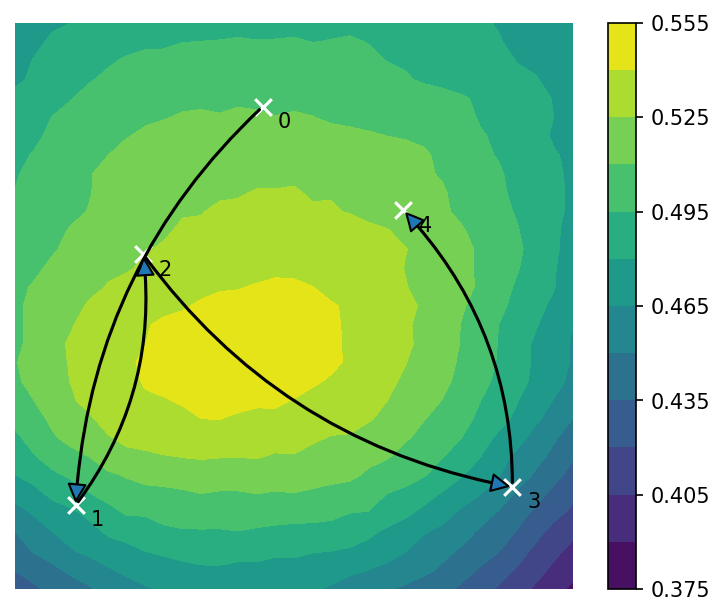

In [13]:
import matplotlib.patches as patches

ARROW_STYLE = "Simple, tail_width=0.5, head_width=8, head_length=8"

fig, ax = plt.subplots(1, 1, dpi=150, figsize=(6, 5))

cbar = ax.contourf(x_grid, y_grid, accs, levels=10)
ax.scatter(fitted_weight_space[:, 0], fitted_weight_space[:, 1], c='white', marker='x', s=64)
for i in range(len(fitted_weight_space)):
    ax.text(fitted_weight_space[i, 0]+0.5, fitted_weight_space[i, 1]-0.5, s=str(i))
    if (i > 0 and i <= 4) or (i > 5 and i <= 9):
        x_prev, y_prev = fitted_weight_space[i-1, 0], fitted_weight_space[i-1, 1]
        x_curr, y_curr = fitted_weight_space[i, 0], fitted_weight_space[i, 1]
        arr = patches.FancyArrowPatch((x_prev, y_prev), (x_curr, y_curr), arrowstyle=ARROW_STYLE, connectionstyle="arc3, rad=.2")
        fig.gca().add_patch(arr)
    
ax.axis('off')
fig.colorbar(cbar)
fig.show()